<a href="https://colab.research.google.com/github/SchmetterlingIII/D.T./blob/main/extension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extension

- Have a clearer quantification of the results:
    - Coordinate-based heat map that plots the final vector position of all the points but each of those points has a `tag` for its colour (which is its wavelength). A heatmap could be plotted from this.
    - Some type of distribution (wavelength against magnitude of distance from initial point)

### Part I: EyeBall
I would like to do geometric optics on an eye. Not for Andrew French's suggestion of the physics being analysed to help improve people's vision but focusing on raindrops and the refraction of white light in water.

All parameters of this should be accounted for since I want a visualisation - without any quantum effects - of Rayleigh Scattering, where shorter wavelength light scatter more than longer wavelength light.

I would like this to run as a simulation that can be pretty crudely analysed and demonstrated.

*For this section, just a simple plotting of the interaction of a ray onto a surface whose internal refractive index is that of water is all that is necessary.*

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as ipy
import random

This code produces a simple model for a line interacting with the surface of a circle.

The circle, of radius $1$, is first parametrised:
$$x = \cos(t)$$
$$y = \sin(t)$$
However, the unparametrised form is still:
$$x^2 + y^2 = 1$$

I then have a randomised line of gradient $m_1$ and y-intercept of $y_1$, in the form:
$$y = m_1(x) + y_1$$

To handle their intersection, I form a quadratic equation:
$$(m_1(x) + y_1)^2 + (x)^2 = 1$$
Which rearranges to:
$$(m_1^2 + 1)x^2 + (2m_1y_1)x + (y_1^2 - 1)$$

The values of the discriminants of these will quantify whether there is an intersection with the circle, whether the ray is tangential, or whether there isn't an intersection.




In [16]:
# circle
t = np.arange(0, (2 * np.pi), 0.0025)

x = np.cos(t)
y = np.sin(t)

# randomised line
m_1 = np.random.uniform(-1, 1) # gradient
y_1 = np.random.uniform(-1, 1) # y_intercept

a = (m_1 ** 2) + 1
b = (2 * m_1 * y_1)
c = (y_1 ** 2) - 1

### check discriminant
d = (b ** 2) - (4 * a * c)

### solve equation
x_values = []
if d < 0:
    print("There are no real solutions to this.\nOnly a circle will be plotted.")
elif d >= 0:
    print("There are two roots from this.\nThere is a chance that it is tangential, meaning the root is repeated.")
    x1 = (-b+np.sqrt(b**2-4*a*c))/(2*a)
    x2 = (-b-np.sqrt(b**2-4*a*c))/(2*a)
    x_values.extend([x1, x2])

min_x = min(x_values) # where the line first intersects the circle (from the left)

x_l = np.linspace(-5, min_x, 1000)
y_l = (m_1 * x_l) + y_1

# refraction handling
n_1 = 1 # air
n_2 = 13.3 # water

theta_1 = np.arctan(m_1) # converts the initial randomised gradient into an angle
theta_2 = np.arcsin((n_1 / n_2) * np.sin(theta_1))  # Correct Snell's law

m_2 = np.tan(theta_2) # gradient of refracted ray
x_i, y_i = min_x, ((m_1 * min_x) + y_1) # intersection points of incident line and circle

x_r = np.linspace(x_i, 10, 1000) # I will calculate the emergent point later
y_r = m_2 * (x_r - x_i) + y_i

There are two roots from this.
There is a chance that it is tangential, meaning the root is repeated.


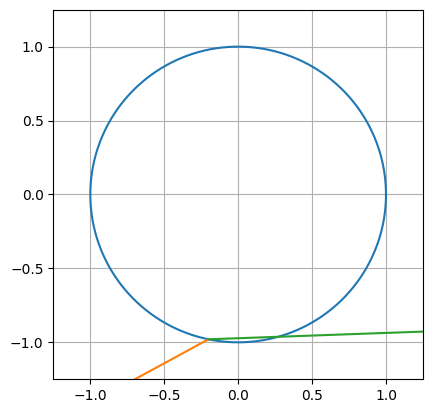

In [4]:
fig, ax = plt.subplots()

ax.plot(x,y)
ax.plot(x_l, y_l)
ax.plot(x_r, y_r)

ax.set_xlim(-1.25, 1.25)
ax.set_ylim(-1.25, 1.25)
ax.set_aspect(1)
ax.grid()

### Part II: Classes & Boids
The detailed model of the one *EyeBall* can then be "extrapolated" onto an $n$-number of raindrops where an array of white light can be shone onto the environment and these reactions can take place to show what is happening

In [17]:
import sympy as sym
import matplotlib.cm as cm

In [3]:
a = (8, 9)
b = np.array(a)
c = a/np.linalg.norm(a)
print(c)

[0.66436384 0.74740932]


In [18]:
'''
Colour Map
'''

c = 3e8
wavelength_nanometres = np.arange(405, 795, 1)
true_wavelength_list = wavelength_nanometres * 1e-9
frequency_list = c / true_wavelength_list

embed_1 = np.sqrt(1/(1.731 - 0.261 *((frequency_list/(10**15))**2)))
n_discrete = np.sqrt(embed_1 + 1)

n_array = np.array(n_discrete)
colours = cm.rainbow(np.linspace(0,1,len(n_array)))

def wavelength_to_colour(wavelength_nm):
    # Map wavelength directly to rainbow colormap
    # 405nm = violet (0), 795nm = red (1)
    normalized = (wavelength_nm - 405) / (795 - 405)
    return cm.rainbow(normalized)

In [19]:
'''
Ray Class
'''

class Ray:
    def __init__(self, position, direction, wavelength):
        self.position = position # starting vector position on the map
        self.direction = direction/np.linalg.norm(direction) # normalised value
        self.wavelength = wavelength # nanometre input

        """
        I initially included intensity into this model, but I do not understand how I would incorporate this into the vector display of the rays.
        If I have the time later, I will add it.
        """

    def get_refractive_index(self):
        w = self.wavelength * 1e-9 # convert nanometre input into metres
        f = c / w
        n = np.sqrt(1 + (np.sqrt(1/(1.731 - 0.261 * ((f/1e15) ** 2)))))

        ## find the position of the refractive index in n_list by finding its closest value
        ## previously I tried to find the exact value but floating point error (again)
        ## meaning it has to be handled (relatively) approximately
        ## by finding the value in the list that minimises the distance between the value and some value in the set list
        n_index = (np.abs(n_array - n)).argmin()

        ## index the same in the colours list
        colour = colours[n_index]
        colour = wavelength_to_colour(self.wavelength)

        return n, colour

    def ray_plotting(self): # this type of plotting only occurs if there is no intersection between a ray and a raindrop
        n, colour = self.get_refractive_index()

        dx, dy = self.direction[0], self.direction[1]
        x, y = self.position[0], self.position[1]
        t = np.linspace(0, 500, 10000)
        x_plot = [(x + t * dx) for t in t]
        y_plot = [(y + t * dy) for t in t]

        return [(x_plot, y_plot), colour]

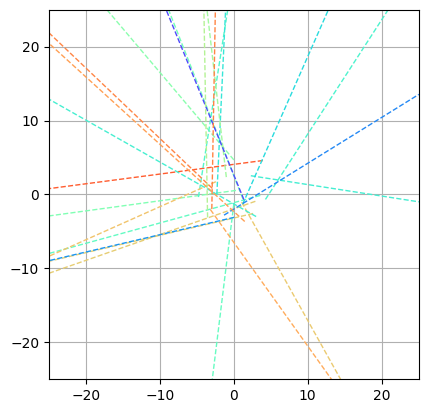

In [20]:
'''
Test of above class structure
'''
for i in range(25):
    a = np.random.uniform(-5,5)
    b = np.random.uniform(-5,5)
    c = np.random.uniform(-5,5)
    d = np.random.uniform(-5,5)
    e = np.random.choice(np.arange(405, 795, 1))

    ray = Ray((a,b), (c,d), e)
    plotting, colour = ray.ray_plotting()
    plt.plot(plotting[0], plotting[1], "--", color=colour, linewidth=1)

lim = 25

plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.gca().set_aspect(1)
plt.grid()
plt.show()

One issue with this class was determining how to handle intersections, especially given the two solutions that occur when a line first intersects with a ray - it is no longer trivial to just choose the left side of the raindrop since TIR could cause the ray of light to enter from the right of the circle.

One other issue was if `dx` was equal to zero (i.e. pointing directly upwards). Although improbable, it would cause the code to crash unexpectedly and divisions by very small numbers can have an accumulation of errors (because again, floating point).

Therefore, I parametrised the linear equations. Rather than:
$$y = mx + c$$
I used:
$$
y = dy\times t + y_1 \\\
x = dx\times t + x_1
$$
Or:
$$
S(t) = \begin{bmatrix} (dx \times t) + x_1 \\ (dy \times t) + y_1 \end{bmatrix}
$$

This vectorisation helped to mitigate many of the floating point errors (that I spent too much time debugging)

In [21]:
class RainDrop:
    def __init__(self, centre, radius):
        self.centre = centre
        self.radius = radius

    def equation(self):
        t = np.linspace(0, 2*np.pi, 1000)

        x = self.radius * np.cos(t)
        y = self.radius * np.sin(t)

        return [(x + self.centre[0]),(y + self.centre[1])]

    def find_intersection(self, ray):
        x_1, y_1 = ray.position # starting point of ray
        dx, dy = ray.direction  # direction vector
        x_2, y_2 = self.centre  # circle centre
        r = self.radius

        # parametric equations in terms of t: at^2 + bt + c = 0
        # x = x_1 + t * dx ; y = y_1 + t * dy
        """
        This can handle when dx=0 which is much more likely in this instance given how many rays there will be.
        Thus, I will use this parametric form.
        """
        a = dx**2 + dy**2                           # t**2
        b = 2*(dx*(x_1 - x_2) + dy*(y_1 - y_2))     # t
        c = (x_1 - x_2)**2 + (y_1 - y_2)**2 - r**2  # constant

        # discriminant conditionals
        d = b**2 - 4*a*c

        """
        Return options:
        1. Two distinct roots
        2. Repeated root
        3. They do not intersect therefore output is None # this shoudld be handled well in other circumstances
        """

        if d < 0: # no real solutions
            return None

        # this handles repeated roots as well
        t1 = (- b + np.sqrt(d)) / (2 * a)
        t2 = (- b - np.sqrt(d)) / (2 * a)

        """
        Floating point erros have been the antagonist to this story.
        Never use 0, always use EPSILON
        """
        EPSILON = 1e-6
        # validate t and choose the closest intersection point
        # otherwise it would randomly migrate to the other side of the raindrop
        validated_t = [t for t in [t1, t2] if t>=EPSILON]

        if len(validated_t) == 0:
            return None

        else:
            t = min(validated_t)
            x = x_1 + t*dx
            y = y_1 + t*dy

            return (x,y)

    def get_surface_normal(self, intersection_point):
        if intersection_point is None:
            print("These points do not intersect") # can only do this with initial tests of the code
            return None
        else:
            cx, cy = self.centre
            ix, iy = intersection_point

            # Vector from center to intersection
            normal_x = (ix - cx) / self.radius
            normal_y = (iy - cy) / self.radius

            m = normal_y/normal_x

            return (normal_x, normal_y)

    def TIR_handle(self, incident, normal):
        incident_ray = incident
        surface_normal = normal

        unit_normal = surface_normal / np.linalg.norm(surface_normal)

        # Calculate the dot product: v . n_hat
        dot_product = np.dot(incident_ray, unit_normal)

        # Apply the standard reflection formula: v_ref = v - 2 * (v . n_hat) * n_hat
        reflected_ray = incident_ray - 2 * dot_product * unit_normal

        return reflected_ray

    def refraction_ray(self, ray, intersection_point):
        """
        The change from the previous code is present in the writeup.
        The main issue with that was the frequent square root aggregated the effects of floating point error, which isn't good.
        """
        # Conditions: find the dot product of the normal and incident to see its direction initially
        # This will determine the final step
        normal = self.get_surface_normal(intersection_point)
        incident = ray.direction

        # Normalize both vectors
        normal = normal / np.linalg.norm(normal)
        incident = incident / np.linalg.norm(incident)

        # Determine entering/exiting
        to_center = self.centre - intersection_point
        entering = np.dot(incident, to_center) > 0
        if entering:
            n1, n2 = 1.0, ray.get_refractive_index()[0]
            # Decompose
            incident_parallel = np.dot(incident, normal) * normal # normal component
            incident_perp = incident - incident_parallel # tangent component

            # Apply Snell's law to perpendicular part
            refracted_perp = (n1 / n2) * incident_perp
        else:
            n1, n2 = ray.get_refractive_index()[0], 1.0
            # Decompose
            incident_parallel = np.dot(incident, normal) * normal # normal component
            incident_perp = incident - incident_parallel # tangent component

            # Apply Snell's law to perpendicular part
            refracted_perp = (n2 / n1) * incident_perp

        # Parallel part from magnitude relation
        mag_refracted_parallel_sq = 1 - np.linalg.norm(refracted_perp)**2
        if mag_refracted_parallel_sq < 0:
            return self.TIR_handle(incident, normal)
            # more information in the writeup

        # Apply sign convention
        if entering:
            refracted_parallel = -np.sqrt(mag_refracted_parallel_sq) * normal

        else:
            refracted_parallel = np.sqrt(mag_refracted_parallel_sq) * normal

        refracted = refracted_perp + refracted_parallel
        return refracted / np.linalg.norm(refracted)

Main code for the running of the classes all together.

In [34]:
def atmosphere_plotting(num_rays=1, num_raindrops=1, max_L=1, lim=10):
    fig, ax = plt.subplots(figsize=(5,5))

    # constants
    lim = lim
    domain_bounds = [-lim, lim]
    max_L = max_L
    eps = 1e-7 # to handle division by zero (in a lazy way)

    # definitions
    ray_list = []
    raindrop_list = []
    final_positions = []

    ## define rays - as a controlled beam
    beam_width = lim * 0.01
    y_positions = np.linspace(-beam_width / 2, beam_width / 2, num_rays)

    for y_pos in y_positions:
        rand_wl = np.random.choice(np.arange(406, 795, 1)) # randomised wavelength
        ray = Ray((-lim, y_pos), (1, 0), rand_wl)
        colour = ray.get_refractive_index()[1]
        ray_list.append((ray, colour))

    ## define raindrops
    for each_raindrop in range(num_raindrops):
        rand_centre = [np.random.uniform(-lim,lim) for i in range(2)]
        rand_radius = np.random.uniform(0.05, 0.3)
        raindrop = RainDrop((rand_centre[0], rand_centre[1]), rand_radius)
        rain = raindrop.equation()
        raindrop_list.append(raindrop)
        ax.fill(rain[0], rain[1], color='lightblue', alpha=0.7)
        ax.plot(rain[0], rain[1], "--", color='k', linewidth=1, alpha=0.8)

    # set plotting environment
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim, lim)

    for each_ray in ray_list:
        path_segments = []
        total_length = 0 # magnitude(path_segments)
        iteration_count = 0
        ray = each_ray[0]
        colour = each_ray[1]
        wavelength = ray.wavelength
        final_positions.append((path_segments, wavelength))

        ## an exceptionally clunky way of defining whether the ray is in the plotting environemnt **and** is less than total length
        while total_length < max_L:
            iteration_count += 1
            # safety check break for debugging
            ## to handle floating point nonsense
            if iteration_count > 200:
                print(f"Breaking after {iteration_count} iterations")
                print(f"Ray position: {ray.position}")
                print(f"Ray direction: {ray.direction}")
                print(f"Total length: {total_length}")
                break

            intersections_found = []
            for raindrop in raindrop_list:
                ray.position = np.array(ray.position)
                # if intersection
                if raindrop.find_intersection(ray) is not None:
                    # add coordinate to intersections_found
                    ## also add the associated raindrop that goes with it
                    ## this will help later (for the refraction calculation)
                    intersection_coordinate = np.array(raindrop.find_intersection(ray))
                    intersections_found.append( (intersection_coordinate, raindrop) )

            # check if list is empty, handle this case for plotting
            if len(intersections_found) == 0:
                """
                Initially plotted a line from the ray.position_x_value to right side of the domain boundary.
                This handles it better (at it can now leave out of any boundary (important if it turns to the left))
                """
                t_values = []

                # right boundary: x = domain_bounds[1]
                if ray.direction[0] > 0:
                    t_right = (domain_bounds[1] - ray.position[0]) / ray.direction[0]
                    t_values.append(t_right)

                # left boundary: x = domain_bounds[0]
                if ray.direction[0] < 0:
                    t_left = (domain_bounds[0] - ray.position[0]) / ray.direction[0]
                    t_values.append(t_left)

                # top boundary: y = domain_bounds[1]
                if ray.direction[1] > 0:
                    t_top = (domain_bounds[1] - ray.position[1]) / ray.direction[1]
                    t_values.append(t_top)

                # bottom boundary: y = domain_bounds[0]
                if ray.direction[1] < 0:
                    t_bottom = (domain_bounds[0] - ray.position[1]) / ray.direction[1]
                    t_values.append(t_bottom)

                # find smallest positive t (closest boundary)
                pos_t_values = ([t for t in t_values if t > 0])
                if not pos_t_values:
                    break
                t_exit = min(pos_t_values)
                boundary_point = ray.position + t_exit * ray.direction

                # The ray travels in a straight line for the rest of its allowed length.
                remaining_length = max_L - total_length
                final_point = ray.position + remaining_length * ray.direction

                path_segments.append((ray.position, final_point))
                total_length += remaining_length
                break

            # choose the coordinate who is closest to this intersection point
            # do this by finding the index of the closest one
            ## length between points
            intersection_lengths = [np.linalg.norm(point - ray.position) for point, rd in intersections_found]
            min_index = intersection_lengths.index(min(intersection_lengths))

            intersection_coordinate = intersections_found[min_index][0]
            ## determine which raindrop corresponds to the closest intersection point
            closest_raindrop = intersections_found[min_index][1]

            segment_start = ray.position
            segment_end = intersection_coordinate
            segment_vector = segment_end - segment_start
            segment_length = np.linalg.norm(segment_vector)
            remaining_length_needed = max_L - total_length

            if segment_length >= remaining_length_needed:
                # if segment is too long, trim it to the remaining length
                unit_vector = segment_vector / segment_length
                final_end_point = segment_start + remaining_length_needed * unit_vector
                path_segments.append((segment_start, final_end_point))
                total_length += remaining_length_needed
                ray.position = final_end_point # update final pos
                break
            else:
                # segment fits, add it and update the ray for the next iteration
                path_segments.append((segment_start, segment_end))
                total_length += segment_length

                new_direction = closest_raindrop.refraction_ray(ray, segment_end)

            if new_direction is None: # error handling
                break
            ## then find the direction of the new ray
            ray.position = segment_end # update the ray position to equate the intersections after it has been refracted
                                                # this way, there can be a cohesive linear piecewise plot
            ray.direction = new_direction
        path_array = np.array(path_segments) # converting the coordinate list into a numpy array
                                             # since path_segments[:][0] is not allowed

        for start, end in path_segments:
            ax.plot([start[0], end[0]], [start[1], end[1]], color=colour)

    ax.grid()
    ax.set_aspect(1)
    plt.show()
    return fig, ax, final_positions

In [ ]:
ipy.interact_manual(atmosphere_plotting, num_rays=(1,1500,1), num_raindrops=(1, 5000, 1), max_L=(0.5, 100, 0.1), lim=(0.5, 100, 1))

### Part III: Data Analysis
Since scattering tends to be dependent on wavelength, modelling out the deviation of the rays of light would be a more important measure - plotting angle deviation against the density of points that also had similar wavelength.

Therefore, I hope to model out a distribution of sorts that -- as different colours are overlayed -- the distribution of all wavelengths of light follow a similar pattern which indicates that white light will be demonstrated.

#### Plan
The heatmap idea will need a database that will, for the coding of each of the nodes to have a colour that changes depending on the attribute of the position.

Further, with the simple plot, I was thinking of trying to fit the curvatures with this (only working with the `.csv` file) and seeing what general distribution of data emerges from this (as part of the outputs for the portfolio alongside other coded aspects).

This can then help with my exploration (or lack thereof) of Mie Scattering and using this as a pretty abstract window into data analysis.

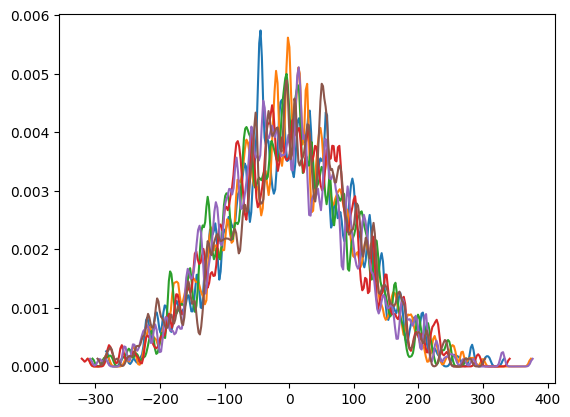

In [32]:
from scipy.stats import gaussian_kde

'''
Below is a statistics test of how I want to distribute this data properly.
I had randomly distributed data and wanted to have a distribution that can account for them.

Since I had only understood distributions are either being perfectly normal or discrete (in the case of histograms) it was necessary to test out with other types of distributions to make sure that this works well.

Kernal Distribution Estimation (KDE) seems to be the best bet
'''

data = np.random.normal(0, 100, 1000)
kde = gaussian_kde(data)
kde.set_bandwidth(bw_method=0.03)
x_range = np.linspace(data.min(), data.max(), 300)
plt.plot(x_range, kde(x_range))
plt.show()

From this, I now need to extract:
- deviated angle from each of the outputted rays
- their corresponding wavelength (which I can then use to call their colour)

I can then plot two graphs:
- holistic distribution of angle deviation
- overlayed graphs of angle deviation of different wavelenghts of light and, if they follow a similar distribution, then I can conclude that it follows Mie Scattering (in the most abstract form).

In [12]:
import pandas as pd
import csv
import os

In [13]:
# random seed for data storage
random_seed = np.random.get_state()[1]
random_index = np.random.randint(0, len(random_seed))

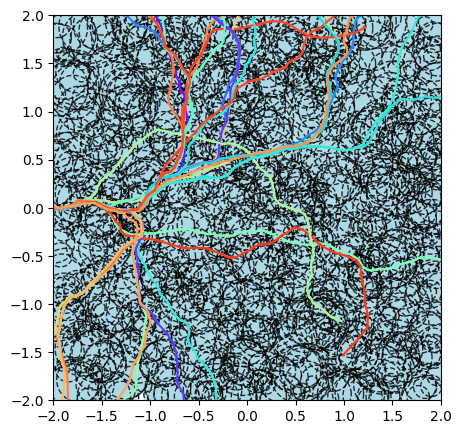

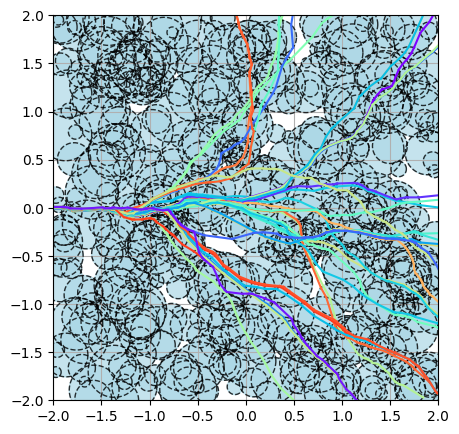

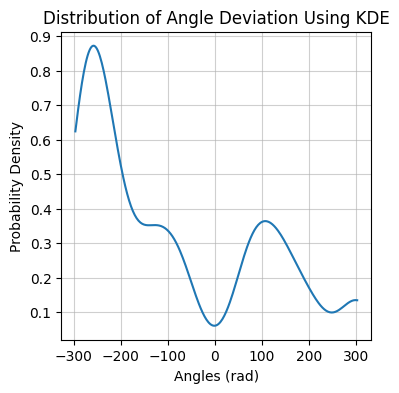

In [84]:
# collect the data from the `atmosphere_plotting` function
plt.ioff()
fig, ax, data = atmosphere_plotting(num_rays=35, num_raindrops=500, max_L=5, lim=2)
plt.close(fig)

fig, (ax, ax2) = plt.subplots(2, figsize=(10,4))

pandas_dict = []

# extract and calculate the wavelength and deviated angle
# the final positions will always have an arctan that approaches 0 since the differences in their y-value will be a very small dy
for ray in data:
    try:
        pos_0 = np.array(ray[0][-1][0])
        pos_1 = np.array(ray[0][-1][1])
        # print(pos_0, pos_1)

        dir = np.array(pos_1) - np.array(pos_0)
        dir = dir / np.linalg.norm(dir)
        # print(dir)

        angles = np.arctan2(dir[1], dir[0])
        wavelength = data[1]
        pandas_dict.append({
            'angle (rad)': angles,
            'wavelength': wavelength
        })
    except LinAlgError:
        print("There has been, effectively, no deviation")

df = pd.DataFrame(pandas_dict)

df.style.format({
    'angle (rad)': '{:.5f}',
    'wavelength': '{:.0f}',
}).hide(axis='index')
## print(df)

# extract angles
angles = df['angle (rad)']
# extract wavelength
wavelength = df['wavelength']
## print(angles)

# do the plot for the distribution (holistically)
kde = gaussian_kde(angles)
kde.set_bandwidth(bw_method=0.2)
x_values = np.linspace(angles.min(), angles.max(), 300)
ax.plot(x_range, kde(x_values))
ax.grid(alpha=0.6)
ax.set_title('Distribution of Angle Deviation Using KDE')
ax.set_ylabel('Probability Density')
ax.set_xlabel(r'Angles (rad)')

'''
On this other plot, I will separate the data points by ranges of wavelength and plot them.
'''
if wavelength
ax2.
plt.show()

Storing the code into a `.csv` file to run tests with a larger dataset.


Store this attempt into a .csv file and then use a large scale aggregate of data.
To realise which data I had used in this file calling, I will give it a random seed at each time that I run this (that I will store as the key in a separate code cell)



In [ ]:

folder = '/content/drive/MyDrive/colab-data-test'
os.makedirs(folder, exist_ok=True) # creating the folder/verifying that it exists before running the .csv

filepath = f'{folder}/distribution-data.csv'

try:
    with open(filepath, 'x', newline='') as f:
        csv.writer(f).writerow(['wavelength', 'y-position', 'random-seed'])

except FileExistsError: # this will be raised on every instance after it has first been made and updated
    pass

with open(filepath, 'a', newline='') as f:
    writer = csv.writer(f)
    writer.writerow([angle, wavelength, random_seed[random_index]])

## plot line of best fit, with the stated deviation from that being demonstrated
